In [2]:
import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Загружаем данные

In [3]:
path_to_train='Train/'
path_to_test='Test/'

In [4]:
X_train=np.load(path_to_train+"X_train.npy")
y_train=np.load(path_to_train+"y_train.npy")
X_test=np.load(path_to_test+"X_test.npy")
y_test=np.load(path_to_test+"y_test.npy")

In [5]:
print(X_train.shape, y_train.shape)

(19267, 12000) (19267,)


In [6]:
pd.array(y_train).value_counts()

0    8564
2    4698
1    3706
3    1819
4     480
dtype: Int64

Классы несбалансированы. Будем с этим бороться

In [7]:
from imblearn.over_sampling import SMOTE

nm=SMOTE()
X_train, y_train=nm.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape)

(42820, 12000) (42820,)


In [8]:
pd.array(y_train).value_counts()

0    8564
1    8564
2    8564
4    8564
3    8564
dtype: Int64

## Обучение

In [9]:
def train(epoch,my_model):
    losses=[]
    my_model.train()
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = my_model(X_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X_batch), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.data.numpy())
    return np.mean(losses)

## Тестирование

In [10]:
def test(my_model):
    my_model.eval()
    test_loss = 0
    correct = 0
    for X_batch, y_batch in test_loader:
        output = my_model(X_batch)
        test_loss += loss_function(output, y_batch).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y_batch.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader)
    acc=correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc,test_loss

## Матрица ошибок

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score

def print_confusion_matrix(model, X, y):
    model.eval()
    y_pred = model(torch.Tensor(X)).data.numpy().argmax(axis = 1)
    print(confusion_matrix(y, y_pred))
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy = {accuracy}")
    return accuracy

In [12]:
batch_size=64
input_shape=X_train.shape[1]

In [13]:
X_train=X_train.reshape(X_train.shape[0],1,12000)
X_test=X_test.reshape(X_test.shape[0],1,12000)

In [14]:
X_train.shape

(42820, 1, 12000)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


# Model1

In [15]:
model1=nn.Sequential()
model1.add_module("conv1",nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3))
model1.add_module("relu1",nn.ReLU())
model1.add_module("flatten",nn.Flatten())
model1.add_module("dense1",nn.Linear((input_shape-3+1)*16,128))
model1.add_module("bn1",nn.BatchNorm1d(128))
model1.add_module("drop1", nn.Dropout(0.5))
model1.add_module("relu2",nn.ReLU())
model1.add_module("dense2",nn.Linear(128,128))
model1.add_module("drop2", nn.Dropout(0.5))
model1.add_module("relu3",nn.ReLU())
model1.add_module("dense3", nn.Linear(128,5))
model1.add_module("softmax",nn.Softmax(dim=1))

In [16]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(),lr=0.0001)

In [17]:
loss_train1=[]
loss_test1=[]
acc1=[]
for epoch in range(50):
    loss_train1.append(train(epoch + 1,model1))
    acc_,test_loss_=test(model1)
    acc1.append(acc_)
    loss_test1.append(test_loss_)

Train Epoch: 1 [0/42820 (0%)]	Loss: 1.611840
Train Epoch: 1 [6400/42820 (15%)]	Loss: 1.455940
Train Epoch: 1 [12800/42820 (30%)]	Loss: 1.424948
Train Epoch: 1 [19200/42820 (45%)]	Loss: 1.393638
Train Epoch: 1 [25600/42820 (60%)]	Loss: 1.287181
Train Epoch: 1 [32000/42820 (75%)]	Loss: 1.334113
Train Epoch: 1 [38400/42820 (90%)]	Loss: 1.327381

Test set: Average loss: 1.4550, Accuracy: 998/2163 (46.14%)

Train Epoch: 2 [0/42820 (0%)]	Loss: 1.192832
Train Epoch: 2 [6400/42820 (15%)]	Loss: 1.219466
Train Epoch: 2 [12800/42820 (30%)]	Loss: 1.206897
Train Epoch: 2 [19200/42820 (45%)]	Loss: 1.254209
Train Epoch: 2 [25600/42820 (60%)]	Loss: 1.222945
Train Epoch: 2 [32000/42820 (75%)]	Loss: 1.199989
Train Epoch: 2 [38400/42820 (90%)]	Loss: 1.298582

Test set: Average loss: 1.3870, Accuracy: 1125/2163 (52.01%)

Train Epoch: 3 [0/42820 (0%)]	Loss: 1.117596
Train Epoch: 3 [6400/42820 (15%)]	Loss: 1.149706
Train Epoch: 3 [12800/42820 (30%)]	Loss: 1.088262
Train Epoch: 3 [19200/42820 (45%)]	Loss: 1.

Train Epoch: 21 [0/42820 (0%)]	Loss: 0.927497
Train Epoch: 21 [6400/42820 (15%)]	Loss: 1.001460
Train Epoch: 21 [12800/42820 (30%)]	Loss: 0.980653
Train Epoch: 21 [19200/42820 (45%)]	Loss: 0.997955
Train Epoch: 21 [25600/42820 (60%)]	Loss: 0.987729
Train Epoch: 21 [32000/42820 (75%)]	Loss: 0.974612
Train Epoch: 21 [38400/42820 (90%)]	Loss: 0.975159

Test set: Average loss: 1.3342, Accuracy: 1206/2163 (55.76%)

Train Epoch: 22 [0/42820 (0%)]	Loss: 1.017678
Train Epoch: 22 [6400/42820 (15%)]	Loss: 0.993552
Train Epoch: 22 [12800/42820 (30%)]	Loss: 0.952485
Train Epoch: 22 [19200/42820 (45%)]	Loss: 1.030342
Train Epoch: 22 [25600/42820 (60%)]	Loss: 0.960024
Train Epoch: 22 [32000/42820 (75%)]	Loss: 0.974015
Train Epoch: 22 [38400/42820 (90%)]	Loss: 1.018535

Test set: Average loss: 1.3273, Accuracy: 1234/2163 (57.05%)

Train Epoch: 23 [0/42820 (0%)]	Loss: 1.047421
Train Epoch: 23 [6400/42820 (15%)]	Loss: 0.993422
Train Epoch: 23 [12800/42820 (30%)]	Loss: 1.065357
Train Epoch: 23 [19200/42


Test set: Average loss: 1.3284, Accuracy: 1232/2163 (56.96%)

Train Epoch: 41 [0/42820 (0%)]	Loss: 0.958001
Train Epoch: 41 [6400/42820 (15%)]	Loss: 0.921308
Train Epoch: 41 [12800/42820 (30%)]	Loss: 0.922254
Train Epoch: 41 [19200/42820 (45%)]	Loss: 0.956600
Train Epoch: 41 [25600/42820 (60%)]	Loss: 0.953478
Train Epoch: 41 [32000/42820 (75%)]	Loss: 0.943800
Train Epoch: 41 [38400/42820 (90%)]	Loss: 0.937000

Test set: Average loss: 1.3231, Accuracy: 1246/2163 (57.61%)

Train Epoch: 42 [0/42820 (0%)]	Loss: 0.947253
Train Epoch: 42 [6400/42820 (15%)]	Loss: 0.943054
Train Epoch: 42 [12800/42820 (30%)]	Loss: 0.955093
Train Epoch: 42 [19200/42820 (45%)]	Loss: 0.976260
Train Epoch: 42 [25600/42820 (60%)]	Loss: 0.931115
Train Epoch: 42 [32000/42820 (75%)]	Loss: 0.954324
Train Epoch: 42 [38400/42820 (90%)]	Loss: 0.936733

Test set: Average loss: 1.3338, Accuracy: 1221/2163 (56.45%)

Train Epoch: 43 [0/42820 (0%)]	Loss: 0.925955
Train Epoch: 43 [6400/42820 (15%)]	Loss: 0.937201
Train Epoch: 

In [18]:
print_confusion_matrix(model1, X_test, y_test)

[[808  65  62  24   5]
 [151 131  76  50   1]
 [144 104 229  33   9]
 [ 81  47  27  58   2]
 [ 38   7   7   2   2]]
Accuracy = 0.5677300046232086


0.5677300046232086

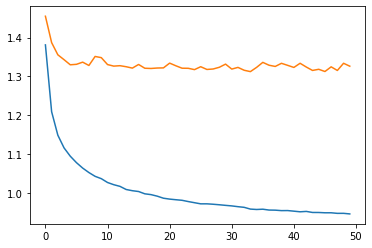

In [19]:
plt.plot(loss_train1)
plt.plot(loss_test1)
plt.show()

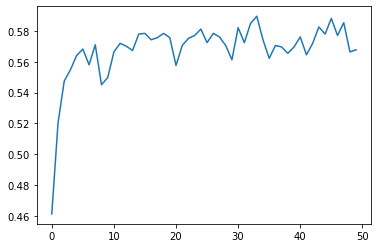

In [20]:
plt.plot(acc1)
plt.show()

In [22]:
print("Best accuracy: ",np.max(acc1)," Epoch: ", np.argmax(acc1))

Best accuracy:  0.58945906  Epoch:  33


# Model2

In [26]:
model2=nn.Sequential()
model2.add_module("conv1",nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3))
model2.add_module("bn1",nn.BatchNorm1d(16))
model2.add_module("relu1",nn.ReLU())
model2.add_module("flatten",nn.Flatten())
model2.add_module("dense1",nn.Linear((input_shape-3+1)*16,128))
model2.add_module("bn2",nn.BatchNorm1d(128))
model2.add_module("drop1", nn.Dropout(0.5))
model2.add_module("relu2",nn.ReLU())
model2.add_module("dense2",nn.Linear(128,128))
model2.add_module("drop2", nn.Dropout(0.5))
model2.add_module("relu3",nn.ReLU())
model2.add_module("dense3", nn.Linear(128,5))
model2.add_module("softmax",nn.Softmax(dim=1))

In [27]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

In [28]:
loss_train2=[]
loss_test2=[]
acc2=[]
for epoch in range(50):
    loss_train2.append(train(epoch + 1,model2))
    acc_,test_loss_=test(model2)
    acc2.append(acc_)
    loss_test2.append(test_loss_)

Train Epoch: 1 [0/42820 (0%)]	Loss: 1.608440
Train Epoch: 1 [6400/42820 (15%)]	Loss: 1.489782
Train Epoch: 1 [12800/42820 (30%)]	Loss: 1.452903
Train Epoch: 1 [19200/42820 (45%)]	Loss: 1.358350
Train Epoch: 1 [25600/42820 (60%)]	Loss: 1.372858
Train Epoch: 1 [32000/42820 (75%)]	Loss: 1.333548
Train Epoch: 1 [38400/42820 (90%)]	Loss: 1.264386

Test set: Average loss: 1.4484, Accuracy: 1008/2163 (46.60%)

Train Epoch: 2 [0/42820 (0%)]	Loss: 1.352008
Train Epoch: 2 [6400/42820 (15%)]	Loss: 1.272770
Train Epoch: 2 [12800/42820 (30%)]	Loss: 1.191388
Train Epoch: 2 [19200/42820 (45%)]	Loss: 1.152746
Train Epoch: 2 [25600/42820 (60%)]	Loss: 1.156814
Train Epoch: 2 [32000/42820 (75%)]	Loss: 1.181054
Train Epoch: 2 [38400/42820 (90%)]	Loss: 1.224252

Test set: Average loss: 1.3927, Accuracy: 1103/2163 (50.99%)

Train Epoch: 3 [0/42820 (0%)]	Loss: 1.178142
Train Epoch: 3 [6400/42820 (15%)]	Loss: 1.174228
Train Epoch: 3 [12800/42820 (30%)]	Loss: 1.200258
Train Epoch: 3 [19200/42820 (45%)]	Loss: 1

Train Epoch: 21 [0/42820 (0%)]	Loss: 1.012450
Train Epoch: 21 [6400/42820 (15%)]	Loss: 1.145773
Train Epoch: 21 [12800/42820 (30%)]	Loss: 0.973780
Train Epoch: 21 [19200/42820 (45%)]	Loss: 0.985506
Train Epoch: 21 [25600/42820 (60%)]	Loss: 1.032770
Train Epoch: 21 [32000/42820 (75%)]	Loss: 0.968096
Train Epoch: 21 [38400/42820 (90%)]	Loss: 0.973520

Test set: Average loss: 1.3454, Accuracy: 1186/2163 (54.83%)

Train Epoch: 22 [0/42820 (0%)]	Loss: 1.006318
Train Epoch: 22 [6400/42820 (15%)]	Loss: 0.982520
Train Epoch: 22 [12800/42820 (30%)]	Loss: 0.995213
Train Epoch: 22 [19200/42820 (45%)]	Loss: 1.060347
Train Epoch: 22 [25600/42820 (60%)]	Loss: 1.020337
Train Epoch: 22 [32000/42820 (75%)]	Loss: 1.010360
Train Epoch: 22 [38400/42820 (90%)]	Loss: 1.028145

Test set: Average loss: 1.3373, Accuracy: 1210/2163 (55.94%)

Train Epoch: 23 [0/42820 (0%)]	Loss: 0.988181
Train Epoch: 23 [6400/42820 (15%)]	Loss: 0.961719
Train Epoch: 23 [12800/42820 (30%)]	Loss: 0.967936
Train Epoch: 23 [19200/42


Test set: Average loss: 1.3432, Accuracy: 1201/2163 (55.52%)

Train Epoch: 41 [0/42820 (0%)]	Loss: 0.950411
Train Epoch: 41 [6400/42820 (15%)]	Loss: 0.947760
Train Epoch: 41 [12800/42820 (30%)]	Loss: 0.959461
Train Epoch: 41 [19200/42820 (45%)]	Loss: 1.008131
Train Epoch: 41 [25600/42820 (60%)]	Loss: 0.939353
Train Epoch: 41 [32000/42820 (75%)]	Loss: 0.980241
Train Epoch: 41 [38400/42820 (90%)]	Loss: 1.002975

Test set: Average loss: 1.3433, Accuracy: 1186/2163 (54.83%)

Train Epoch: 42 [0/42820 (0%)]	Loss: 0.962300
Train Epoch: 42 [6400/42820 (15%)]	Loss: 0.941717
Train Epoch: 42 [12800/42820 (30%)]	Loss: 0.912780
Train Epoch: 42 [19200/42820 (45%)]	Loss: 0.997845
Train Epoch: 42 [25600/42820 (60%)]	Loss: 0.995651
Train Epoch: 42 [32000/42820 (75%)]	Loss: 0.967949
Train Epoch: 42 [38400/42820 (90%)]	Loss: 0.989610

Test set: Average loss: 1.3356, Accuracy: 1217/2163 (56.26%)

Train Epoch: 43 [0/42820 (0%)]	Loss: 0.970780
Train Epoch: 43 [6400/42820 (15%)]	Loss: 0.955434
Train Epoch: 

In [ ]:
print_confusion_matrix(model2, X_test, y_test)

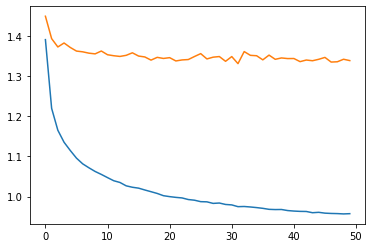

In [36]:
plt.plot(loss_train2)
plt.plot(loss_test2)
plt.show()

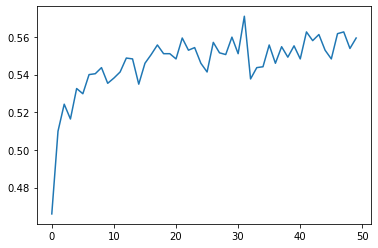

In [37]:
plt.plot(acc2)
plt.show()

In [38]:
print("Best accuracy: ",np.max(acc2)," Epoch: ", np.argmax(acc2))

Best accuracy:  0.57096624  Epoch:  31


# Model3

In [43]:
model3=nn.Sequential()
model3.add_module("conv1",nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3))
model3.add_module("relu1",nn.ReLU())
model3.add_module("maxpool",nn.MaxPool1d(kernel_size = 2))
model3.add_module("flatten",nn.Flatten())
model3.add_module("dense1",nn.Linear((input_shape-3+1)*8,128))
model3.add_module("bn2",nn.BatchNorm1d(128))
model3.add_module("drop1", nn.Dropout(0.5))
model3.add_module("relu2",nn.ReLU())
model3.add_module("dense2",nn.Linear(128,128))
model3.add_module("drop2", nn.Dropout(0.5))
model3.add_module("relu3",nn.ReLU())
model3.add_module("dense3", nn.Linear(128,5))
model3.add_module("softmax",nn.Softmax(dim=1))

In [44]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)

In [45]:
loss_train3=[]
loss_test3=[]
acc3=[]
for epoch in range(50):
    loss_train3.append(train(epoch + 1,model3))
    acc_,test_loss_=test(model3)
    acc3.append(acc_)
    loss_test3.append(test_loss_)

Train Epoch: 1 [0/42820 (0%)]	Loss: 1.611014
Train Epoch: 1 [6400/42820 (15%)]	Loss: 1.482721
Train Epoch: 1 [12800/42820 (30%)]	Loss: 1.431417
Train Epoch: 1 [19200/42820 (45%)]	Loss: 1.394408
Train Epoch: 1 [25600/42820 (60%)]	Loss: 1.368168
Train Epoch: 1 [32000/42820 (75%)]	Loss: 1.263974
Train Epoch: 1 [38400/42820 (90%)]	Loss: 1.331584

Test set: Average loss: 1.5621, Accuracy: 663/2163 (30.65%)

Train Epoch: 2 [0/42820 (0%)]	Loss: 1.233278
Train Epoch: 2 [6400/42820 (15%)]	Loss: 1.226873
Train Epoch: 2 [12800/42820 (30%)]	Loss: 1.224327
Train Epoch: 2 [19200/42820 (45%)]	Loss: 1.300837
Train Epoch: 2 [25600/42820 (60%)]	Loss: 1.151762
Train Epoch: 2 [32000/42820 (75%)]	Loss: 1.204606
Train Epoch: 2 [38400/42820 (90%)]	Loss: 1.208561

Test set: Average loss: 1.4684, Accuracy: 893/2163 (41.29%)

Train Epoch: 3 [0/42820 (0%)]	Loss: 1.168574
Train Epoch: 3 [6400/42820 (15%)]	Loss: 1.168632
Train Epoch: 3 [12800/42820 (30%)]	Loss: 1.262098
Train Epoch: 3 [19200/42820 (45%)]	Loss: 1.1

Train Epoch: 21 [0/42820 (0%)]	Loss: 0.954541
Train Epoch: 21 [6400/42820 (15%)]	Loss: 1.032332
Train Epoch: 21 [12800/42820 (30%)]	Loss: 1.005261
Train Epoch: 21 [19200/42820 (45%)]	Loss: 0.996274
Train Epoch: 21 [25600/42820 (60%)]	Loss: 1.040710
Train Epoch: 21 [32000/42820 (75%)]	Loss: 1.047133
Train Epoch: 21 [38400/42820 (90%)]	Loss: 0.968833

Test set: Average loss: 1.3479, Accuracy: 1189/2163 (54.97%)

Train Epoch: 22 [0/42820 (0%)]	Loss: 0.987277
Train Epoch: 22 [6400/42820 (15%)]	Loss: 0.962668
Train Epoch: 22 [12800/42820 (30%)]	Loss: 0.971994
Train Epoch: 22 [19200/42820 (45%)]	Loss: 1.018188
Train Epoch: 22 [25600/42820 (60%)]	Loss: 0.935483
Train Epoch: 22 [32000/42820 (75%)]	Loss: 1.006186
Train Epoch: 22 [38400/42820 (90%)]	Loss: 1.024712

Test set: Average loss: 1.3404, Accuracy: 1199/2163 (55.43%)

Train Epoch: 23 [0/42820 (0%)]	Loss: 0.984463
Train Epoch: 23 [6400/42820 (15%)]	Loss: 0.968762
Train Epoch: 23 [12800/42820 (30%)]	Loss: 1.019691
Train Epoch: 23 [19200/42


Test set: Average loss: 1.3505, Accuracy: 1181/2163 (54.60%)

Train Epoch: 41 [0/42820 (0%)]	Loss: 0.980028
Train Epoch: 41 [6400/42820 (15%)]	Loss: 0.939607
Train Epoch: 41 [12800/42820 (30%)]	Loss: 0.936678
Train Epoch: 41 [19200/42820 (45%)]	Loss: 0.964953
Train Epoch: 41 [25600/42820 (60%)]	Loss: 0.955063
Train Epoch: 41 [32000/42820 (75%)]	Loss: 1.002009
Train Epoch: 41 [38400/42820 (90%)]	Loss: 0.923982

Test set: Average loss: 1.3704, Accuracy: 1131/2163 (52.29%)

Train Epoch: 42 [0/42820 (0%)]	Loss: 0.954919
Train Epoch: 42 [6400/42820 (15%)]	Loss: 0.987421
Train Epoch: 42 [12800/42820 (30%)]	Loss: 1.017832
Train Epoch: 42 [19200/42820 (45%)]	Loss: 0.931850
Train Epoch: 42 [25600/42820 (60%)]	Loss: 0.963086
Train Epoch: 42 [32000/42820 (75%)]	Loss: 1.045031
Train Epoch: 42 [38400/42820 (90%)]	Loss: 0.949467

Test set: Average loss: 1.3377, Accuracy: 1210/2163 (55.94%)

Train Epoch: 43 [0/42820 (0%)]	Loss: 0.933676
Train Epoch: 43 [6400/42820 (15%)]	Loss: 0.968972
Train Epoch: 

In [ ]:
print_confusion_matrix(model3, X_test, y_test)

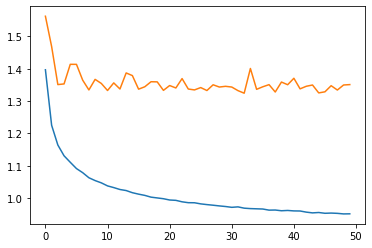

In [46]:
plt.plot(loss_train3)
plt.plot(loss_test3)
plt.show()

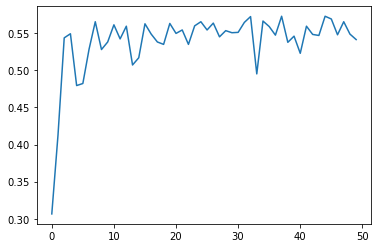

In [47]:
plt.plot(acc3)
plt.show()

In [48]:
print("Best accuracy: ",np.max(acc3)," Epoch: ", np.argmax(acc3))

Best accuracy:  0.57281554  Epoch:  37


# Model4 (Модель №1 в работе)

In [58]:
model4=nn.Sequential()
model4.add_module("conv1",nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3))
model4.add_module("relu1",nn.ReLU())
model4.add_module("conv2",nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size = 5))
model4.add_module("relu2",nn.ReLU())
model4.add_module("flatten",nn.Flatten())
model4.add_module("dense1",nn.Linear((input_shape-3-5+2)*16,128))
model4.add_module("bn2",nn.BatchNorm1d(128))
model4.add_module("drop1", nn.Dropout(0.5))
model4.add_module("relu6",nn.ReLU())
model4.add_module("dense2",nn.Linear(128,128))
model4.add_module("drop2", nn.Dropout(0.5))
model4.add_module("relu7",nn.ReLU())
model4.add_module("dense3", nn.Linear(128,5))
model4.add_module("softmax",nn.Softmax(dim=1))

In [59]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.0001)

In [60]:
loss_train4=[]
loss_test4=[]
acc4=[]
for epoch in range(50):
    loss_train4.append(train(epoch + 1,model4))
    acc_,test_loss_=test(model4)
    acc4.append(acc_)
    loss_test4.append(test_loss_)

Train Epoch: 1 [0/42820 (0%)]	Loss: 1.625840
Train Epoch: 1 [6400/42820 (15%)]	Loss: 1.477504
Train Epoch: 1 [12800/42820 (30%)]	Loss: 1.406568
Train Epoch: 1 [19200/42820 (45%)]	Loss: 1.315536
Train Epoch: 1 [25600/42820 (60%)]	Loss: 1.228575
Train Epoch: 1 [32000/42820 (75%)]	Loss: 1.262908
Train Epoch: 1 [38400/42820 (90%)]	Loss: 1.171088

Test set: Average loss: 1.3265, Accuracy: 1291/2163 (59.69%)

Train Epoch: 2 [0/42820 (0%)]	Loss: 1.210037
Train Epoch: 2 [6400/42820 (15%)]	Loss: 1.120399
Train Epoch: 2 [12800/42820 (30%)]	Loss: 1.139123
Train Epoch: 2 [19200/42820 (45%)]	Loss: 1.084806
Train Epoch: 2 [25600/42820 (60%)]	Loss: 1.142677
Train Epoch: 2 [32000/42820 (75%)]	Loss: 1.153142
Train Epoch: 2 [38400/42820 (90%)]	Loss: 1.040846

Test set: Average loss: 1.3032, Accuracy: 1298/2163 (60.01%)

Train Epoch: 3 [0/42820 (0%)]	Loss: 1.063337
Train Epoch: 3 [6400/42820 (15%)]	Loss: 1.080907
Train Epoch: 3 [12800/42820 (30%)]	Loss: 1.057938
Train Epoch: 3 [19200/42820 (45%)]	Loss: 1

Train Epoch: 21 [0/42820 (0%)]	Loss: 0.936503
Train Epoch: 21 [6400/42820 (15%)]	Loss: 0.961696
Train Epoch: 21 [12800/42820 (30%)]	Loss: 0.915835
Train Epoch: 21 [19200/42820 (45%)]	Loss: 0.909106
Train Epoch: 21 [25600/42820 (60%)]	Loss: 0.951112
Train Epoch: 21 [32000/42820 (75%)]	Loss: 0.920829
Train Epoch: 21 [38400/42820 (90%)]	Loss: 0.905361

Test set: Average loss: 1.2929, Accuracy: 1308/2163 (60.47%)

Train Epoch: 22 [0/42820 (0%)]	Loss: 0.906646
Train Epoch: 22 [6400/42820 (15%)]	Loss: 0.911716
Train Epoch: 22 [12800/42820 (30%)]	Loss: 0.930312
Train Epoch: 22 [19200/42820 (45%)]	Loss: 0.934995
Train Epoch: 22 [25600/42820 (60%)]	Loss: 0.908057
Train Epoch: 22 [32000/42820 (75%)]	Loss: 0.906665
Train Epoch: 22 [38400/42820 (90%)]	Loss: 0.909738

Test set: Average loss: 1.2960, Accuracy: 1302/2163 (60.19%)

Train Epoch: 23 [0/42820 (0%)]	Loss: 0.941808
Train Epoch: 23 [6400/42820 (15%)]	Loss: 0.905115
Train Epoch: 23 [12800/42820 (30%)]	Loss: 0.906621
Train Epoch: 23 [19200/42


Test set: Average loss: 1.2974, Accuracy: 1303/2163 (60.24%)

Train Epoch: 41 [0/42820 (0%)]	Loss: 0.934084
Train Epoch: 41 [6400/42820 (15%)]	Loss: 0.912781
Train Epoch: 41 [12800/42820 (30%)]	Loss: 0.929422
Train Epoch: 41 [19200/42820 (45%)]	Loss: 0.925158
Train Epoch: 41 [25600/42820 (60%)]	Loss: 0.917534
Train Epoch: 41 [32000/42820 (75%)]	Loss: 0.920754
Train Epoch: 41 [38400/42820 (90%)]	Loss: 0.930718

Test set: Average loss: 1.2947, Accuracy: 1308/2163 (60.47%)

Train Epoch: 42 [0/42820 (0%)]	Loss: 0.920516
Train Epoch: 42 [6400/42820 (15%)]	Loss: 0.917750
Train Epoch: 42 [12800/42820 (30%)]	Loss: 0.923950
Train Epoch: 42 [19200/42820 (45%)]	Loss: 0.905484
Train Epoch: 42 [25600/42820 (60%)]	Loss: 0.927640
Train Epoch: 42 [32000/42820 (75%)]	Loss: 0.905252
Train Epoch: 42 [38400/42820 (90%)]	Loss: 0.941160

Test set: Average loss: 1.2987, Accuracy: 1293/2163 (59.78%)

Train Epoch: 43 [0/42820 (0%)]	Loss: 0.927866
Train Epoch: 43 [6400/42820 (15%)]	Loss: 0.936690
Train Epoch: 

In [ ]:
print_confusion_matrix(model4, X_test, y_test)

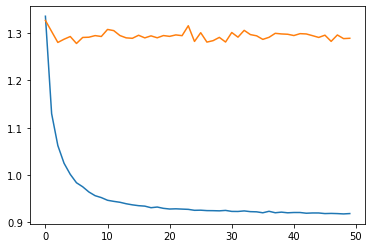

In [61]:
plt.plot(loss_train4)
plt.plot(loss_test4)
plt.show()

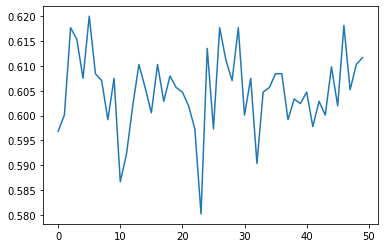

In [62]:
plt.plot(acc4)
plt.show()

In [63]:
print("Best accuracy: ",np.max(acc4)," Epoch: ", np.argmax(acc4))

Best accuracy:  0.6199723  Epoch:  5


# Model5

In [79]:
model5=nn.Sequential()
model5.add_module("conv1",nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3))
model5.add_module("relu1",nn.ReLU())
model5.add_module("conv2",nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size = 5))
model5.add_module("relu2",nn.ReLU())
model5.add_module("conv3",nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size = 7))
model5.add_module("relu3",nn.ReLU())
model5.add_module("flatten",nn.Flatten())
model5.add_module("dense1",nn.Linear((input_shape-3-5-7+3)*16,128))
model5.add_module("bn2",nn.BatchNorm1d(128))
model5.add_module("drop1", nn.Dropout(0.5))
model5.add_module("relu4",nn.ReLU())
model5.add_module("dense2",nn.Linear(128,128))
model5.add_module("drop2", nn.Dropout(0.5))
model5.add_module("relu5",nn.ReLU())
model5.add_module("dense3", nn.Linear(128,5))
model5.add_module("softmax",nn.Softmax(dim=1))

In [80]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.0001)

In [81]:
loss_train5=[]
loss_test5=[]
acc5=[]
for epoch in range(50):
    loss_train5.append(train(epoch + 1,model5))
    acc_,test_loss_=test(model5)
    acc5.append(acc_)
    loss_test5.append(test_loss_)

Train Epoch: 1 [0/42820 (0%)]	Loss: 1.611519
Train Epoch: 1 [6400/42820 (15%)]	Loss: 1.481046
Train Epoch: 1 [12800/42820 (30%)]	Loss: 1.376665
Train Epoch: 1 [19200/42820 (45%)]	Loss: 1.264065
Train Epoch: 1 [25600/42820 (60%)]	Loss: 1.248121
Train Epoch: 1 [32000/42820 (75%)]	Loss: 1.224816
Train Epoch: 1 [38400/42820 (90%)]	Loss: 1.208834

Test set: Average loss: 1.3697, Accuracy: 1145/2163 (52.94%)

Train Epoch: 2 [0/42820 (0%)]	Loss: 1.168068
Train Epoch: 2 [6400/42820 (15%)]	Loss: 1.179365
Train Epoch: 2 [12800/42820 (30%)]	Loss: 1.151966
Train Epoch: 2 [19200/42820 (45%)]	Loss: 1.097073
Train Epoch: 2 [25600/42820 (60%)]	Loss: 1.143133
Train Epoch: 2 [32000/42820 (75%)]	Loss: 1.143588
Train Epoch: 2 [38400/42820 (90%)]	Loss: 1.092921

Test set: Average loss: 1.2895, Accuracy: 1328/2163 (61.40%)

Train Epoch: 3 [0/42820 (0%)]	Loss: 1.097064
Train Epoch: 3 [6400/42820 (15%)]	Loss: 1.058008
Train Epoch: 3 [12800/42820 (30%)]	Loss: 1.093209
Train Epoch: 3 [19200/42820 (45%)]	Loss: 1

Train Epoch: 21 [0/42820 (0%)]	Loss: 0.923005
Train Epoch: 21 [6400/42820 (15%)]	Loss: 1.008459
Train Epoch: 21 [12800/42820 (30%)]	Loss: 0.937183
Train Epoch: 21 [19200/42820 (45%)]	Loss: 0.941433
Train Epoch: 21 [25600/42820 (60%)]	Loss: 0.971198
Train Epoch: 21 [32000/42820 (75%)]	Loss: 0.909344
Train Epoch: 21 [38400/42820 (90%)]	Loss: 0.951059

Test set: Average loss: 1.3010, Accuracy: 1294/2163 (59.82%)

Train Epoch: 22 [0/42820 (0%)]	Loss: 0.944288
Train Epoch: 22 [6400/42820 (15%)]	Loss: 0.931579
Train Epoch: 22 [12800/42820 (30%)]	Loss: 0.916945
Train Epoch: 22 [19200/42820 (45%)]	Loss: 0.937029
Train Epoch: 22 [25600/42820 (60%)]	Loss: 0.998878
Train Epoch: 22 [32000/42820 (75%)]	Loss: 0.908556
Train Epoch: 22 [38400/42820 (90%)]	Loss: 0.936455

Test set: Average loss: 1.3208, Accuracy: 1258/2163 (58.16%)

Train Epoch: 23 [0/42820 (0%)]	Loss: 0.935814
Train Epoch: 23 [6400/42820 (15%)]	Loss: 0.921238
Train Epoch: 23 [12800/42820 (30%)]	Loss: 0.936326
Train Epoch: 23 [19200/42


Test set: Average loss: 1.3304, Accuracy: 1222/2163 (56.50%)

Train Epoch: 41 [0/42820 (0%)]	Loss: 0.905546
Train Epoch: 41 [6400/42820 (15%)]	Loss: 0.904940
Train Epoch: 41 [12800/42820 (30%)]	Loss: 0.936511
Train Epoch: 41 [19200/42820 (45%)]	Loss: 0.905166
Train Epoch: 41 [25600/42820 (60%)]	Loss: 0.925490
Train Epoch: 41 [32000/42820 (75%)]	Loss: 0.951249
Train Epoch: 41 [38400/42820 (90%)]	Loss: 0.904916

Test set: Average loss: 1.3008, Accuracy: 1302/2163 (60.19%)

Train Epoch: 42 [0/42820 (0%)]	Loss: 0.906178
Train Epoch: 42 [6400/42820 (15%)]	Loss: 0.909079
Train Epoch: 42 [12800/42820 (30%)]	Loss: 0.953785
Train Epoch: 42 [19200/42820 (45%)]	Loss: 0.905364
Train Epoch: 42 [25600/42820 (60%)]	Loss: 0.923270
Train Epoch: 42 [32000/42820 (75%)]	Loss: 0.921860
Train Epoch: 42 [38400/42820 (90%)]	Loss: 0.936088

Test set: Average loss: 1.3063, Accuracy: 1281/2163 (59.22%)

Train Epoch: 43 [0/42820 (0%)]	Loss: 0.936051
Train Epoch: 43 [6400/42820 (15%)]	Loss: 0.905581
Train Epoch: 

In [ ]:
print_confusion_matrix(model5, X_test, y_test)

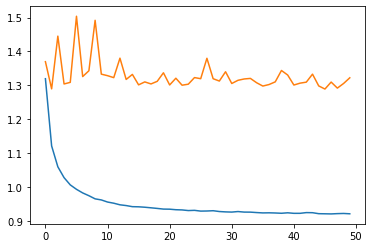

In [82]:
plt.plot(loss_train5)
plt.plot(loss_test5)
plt.show()

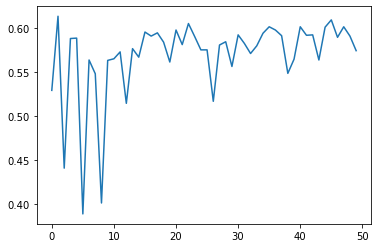

In [83]:
plt.plot(acc5)
plt.show()

In [84]:
print("Best accuracy: ",np.max(acc5)," Epoch: ", np.argmax(acc5))

Best accuracy:  0.6139621  Epoch:  1


# Model6 (Модель №2 в работе)

In [15]:
model6=nn.Sequential()
model6.add_module("conv1",nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 21))
model6.add_module("relu1",nn.ReLU())
model6.add_module("conv2",nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size = 33))
model6.add_module("relu2",nn.ReLU())
model6.add_module("flatten",nn.Flatten())
model6.add_module("dense1",nn.Linear((input_shape-21-33+2)*16,128))
model6.add_module("bn2",nn.BatchNorm1d(128))
model6.add_module("drop1", nn.Dropout(0.5))
model6.add_module("relu6",nn.ReLU())
model6.add_module("dense2",nn.Linear(128,128))
model6.add_module("drop2", nn.Dropout(0.5))
model6.add_module("relu7",nn.ReLU())
model6.add_module("dense3", nn.Linear(128,5))
model6.add_module("softmax",nn.Softmax(dim=1))

In [16]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=0.0001)

In [17]:
loss_train6=[]
loss_test6=[]
acc6=[]
for epoch in range(25):
    loss_train6.append(train(epoch + 1,model6))
    acc_,test_loss_=test(model6)
    acc6.append(acc_)
    loss_test6.append(test_loss_)

Train Epoch: 1 [0/42820 (0%)]	Loss: 1.591540
Train Epoch: 1 [6400/42820 (15%)]	Loss: 1.438686
Train Epoch: 1 [12800/42820 (30%)]	Loss: 1.343393
Train Epoch: 1 [19200/42820 (45%)]	Loss: 1.205049
Train Epoch: 1 [25600/42820 (60%)]	Loss: 1.156271
Train Epoch: 1 [32000/42820 (75%)]	Loss: 1.131380
Train Epoch: 1 [38400/42820 (90%)]	Loss: 1.113918

Test set: Average loss: 1.2870, Accuracy: 1372/2163 (63.43%)

Train Epoch: 2 [0/42820 (0%)]	Loss: 1.051757
Train Epoch: 2 [6400/42820 (15%)]	Loss: 1.038034
Train Epoch: 2 [12800/42820 (30%)]	Loss: 1.059397
Train Epoch: 2 [19200/42820 (45%)]	Loss: 1.032005
Train Epoch: 2 [25600/42820 (60%)]	Loss: 1.068783
Train Epoch: 2 [32000/42820 (75%)]	Loss: 1.038947
Train Epoch: 2 [38400/42820 (90%)]	Loss: 1.041962

Test set: Average loss: 1.3382, Accuracy: 1212/2163 (56.03%)

Train Epoch: 3 [0/42820 (0%)]	Loss: 0.925682
Train Epoch: 3 [6400/42820 (15%)]	Loss: 0.962708
Train Epoch: 3 [12800/42820 (30%)]	Loss: 1.027018
Train Epoch: 3 [19200/42820 (45%)]	Loss: 0

Train Epoch: 21 [0/42820 (0%)]	Loss: 0.905097
Train Epoch: 21 [6400/42820 (15%)]	Loss: 0.905574
Train Epoch: 21 [12800/42820 (30%)]	Loss: 0.936159
Train Epoch: 21 [19200/42820 (45%)]	Loss: 0.912169
Train Epoch: 21 [25600/42820 (60%)]	Loss: 0.920592
Train Epoch: 21 [32000/42820 (75%)]	Loss: 0.918722
Train Epoch: 21 [38400/42820 (90%)]	Loss: 0.919860

Test set: Average loss: 1.2974, Accuracy: 1296/2163 (59.92%)

Train Epoch: 22 [0/42820 (0%)]	Loss: 0.906961
Train Epoch: 22 [6400/42820 (15%)]	Loss: 0.920827
Train Epoch: 22 [12800/42820 (30%)]	Loss: 0.916872
Train Epoch: 22 [19200/42820 (45%)]	Loss: 0.913086
Train Epoch: 22 [25600/42820 (60%)]	Loss: 0.907258
Train Epoch: 22 [32000/42820 (75%)]	Loss: 0.936329
Train Epoch: 22 [38400/42820 (90%)]	Loss: 0.922389

Test set: Average loss: 1.2703, Accuracy: 1357/2163 (62.74%)

Train Epoch: 23 [0/42820 (0%)]	Loss: 0.920905
Train Epoch: 23 [6400/42820 (15%)]	Loss: 0.924520
Train Epoch: 23 [12800/42820 (30%)]	Loss: 0.905995
Train Epoch: 23 [19200/42

In [18]:
print_confusion_matrix(model6, X_test, y_test)

[[814  48  73  29   0]
 [108 164  85  52   0]
 [106  64 318  30   1]
 [ 72  42  23  77   1]
 [ 35   1  14   4   2]]
Accuracy = 0.6356911696717522


0.6356911696717522

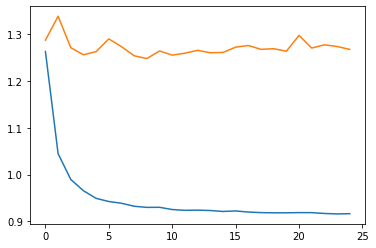

In [19]:
plt.plot(loss_train6)
plt.plot(loss_test6)
plt.show()

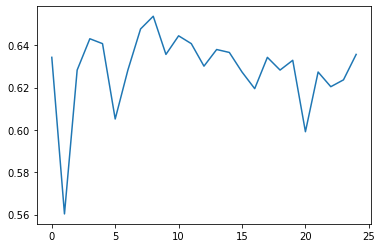

In [20]:
plt.plot(acc6)
plt.show()

In [21]:
print("Best accuracy: ",np.max(acc6)," Epoch: ", np.argmax(acc6))

Best accuracy:  0.6537217  Epoch:  8


# Model7 (Модель №3 в работе)

In [25]:
model7=nn.Sequential()
model7.add_module("conv1",nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 51))
model7.add_module("relu1",nn.ReLU())
model7.add_module("conv2",nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size = 67))
model7.add_module("relu2",nn.ReLU())
model7.add_module("flatten",nn.Flatten())
model7.add_module("dense1",nn.Linear((input_shape-51-67+2)*16,128))
model7.add_module("bn2",nn.BatchNorm1d(128))
model7.add_module("drop1", nn.Dropout(0.5))
model7.add_module("relu6",nn.ReLU())
model7.add_module("dense2",nn.Linear(128,128))
model7.add_module("drop2", nn.Dropout(0.5))
model7.add_module("relu7",nn.ReLU())
model7.add_module("dense3", nn.Linear(128,5))
model7.add_module("softmax",nn.Softmax(dim=1))

In [26]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model7.parameters(), lr=0.0001)

In [27]:
loss_train7=[]
loss_test7=[]
acc7=[]
for epoch in range(25):
    loss_train7.append(train(epoch + 1,model7))
    acc_,test_loss_=test(model7)
    acc7.append(acc_)
    loss_test7.append(test_loss_)

Train Epoch: 1 [0/42820 (0%)]	Loss: 1.589285
Train Epoch: 1 [6400/42820 (15%)]	Loss: 1.460697
Train Epoch: 1 [12800/42820 (30%)]	Loss: 1.322415
Train Epoch: 1 [19200/42820 (45%)]	Loss: 1.298085
Train Epoch: 1 [25600/42820 (60%)]	Loss: 1.135040
Train Epoch: 1 [32000/42820 (75%)]	Loss: 1.134353
Train Epoch: 1 [38400/42820 (90%)]	Loss: 1.078086

Test set: Average loss: 1.2776, Accuracy: 1348/2163 (62.32%)

Train Epoch: 2 [0/42820 (0%)]	Loss: 1.120429
Train Epoch: 2 [6400/42820 (15%)]	Loss: 1.058351
Train Epoch: 2 [12800/42820 (30%)]	Loss: 1.063031
Train Epoch: 2 [19200/42820 (45%)]	Loss: 1.039282
Train Epoch: 2 [25600/42820 (60%)]	Loss: 1.067620
Train Epoch: 2 [32000/42820 (75%)]	Loss: 1.120581
Train Epoch: 2 [38400/42820 (90%)]	Loss: 1.003543

Test set: Average loss: 1.2708, Accuracy: 1357/2163 (62.74%)

Train Epoch: 3 [0/42820 (0%)]	Loss: 0.964449
Train Epoch: 3 [6400/42820 (15%)]	Loss: 0.988193
Train Epoch: 3 [12800/42820 (30%)]	Loss: 0.940123
Train Epoch: 3 [19200/42820 (45%)]	Loss: 1

Train Epoch: 21 [0/42820 (0%)]	Loss: 0.912006
Train Epoch: 21 [6400/42820 (15%)]	Loss: 0.905086
Train Epoch: 21 [12800/42820 (30%)]	Loss: 0.907560
Train Epoch: 21 [19200/42820 (45%)]	Loss: 0.906766
Train Epoch: 21 [25600/42820 (60%)]	Loss: 0.932519
Train Epoch: 21 [32000/42820 (75%)]	Loss: 0.914247
Train Epoch: 21 [38400/42820 (90%)]	Loss: 0.906214

Test set: Average loss: 1.2690, Accuracy: 1365/2163 (63.11%)

Train Epoch: 22 [0/42820 (0%)]	Loss: 0.906852
Train Epoch: 22 [6400/42820 (15%)]	Loss: 0.936662
Train Epoch: 22 [12800/42820 (30%)]	Loss: 0.907919
Train Epoch: 22 [19200/42820 (45%)]	Loss: 0.913760
Train Epoch: 22 [25600/42820 (60%)]	Loss: 0.927395
Train Epoch: 22 [32000/42820 (75%)]	Loss: 0.913107
Train Epoch: 22 [38400/42820 (90%)]	Loss: 0.926760

Test set: Average loss: 1.2542, Accuracy: 1390/2163 (64.26%)

Train Epoch: 23 [0/42820 (0%)]	Loss: 0.905222
Train Epoch: 23 [6400/42820 (15%)]	Loss: 0.921067
Train Epoch: 23 [12800/42820 (30%)]	Loss: 0.938684
Train Epoch: 23 [19200/42

In [28]:
print_confusion_matrix(model7, X_test, y_test)

[[853  50  49  10   2]
 [116 201  74  16   2]
 [100  94 305  17   3]
 [ 67  67  20  60   1]
 [ 36   5  11   1   3]]
Accuracy = 0.6574202496532594


0.6574202496532594

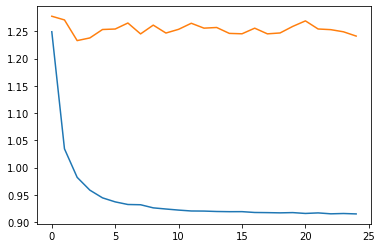

In [29]:
plt.plot(loss_train7)
plt.plot(loss_test7)
plt.show()

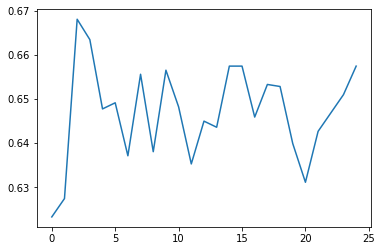

In [30]:
plt.plot(acc7)
plt.show()

In [31]:
print("Best accuracy: ",np.max(acc7)," Epoch: ", np.argmax(acc7))

Best accuracy:  0.6680536  Epoch:  2


# Model8 (Модель №4 в работе)

In [32]:
model8=nn.Sequential()
model8.add_module("conv1",nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 101))
model8.add_module("relu1",nn.ReLU())
model8.add_module("conv2",nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size = 215))
model8.add_module("relu2",nn.ReLU())
model8.add_module("flatten",nn.Flatten())
model8.add_module("dense1",nn.Linear((input_shape-101-215+2)*16,128))
model8.add_module("bn2",nn.BatchNorm1d(128))
model8.add_module("drop1", nn.Dropout(0.5))
model8.add_module("relu6",nn.ReLU())
model8.add_module("dense2",nn.Linear(128,128))
model8.add_module("drop2", nn.Dropout(0.5))
model8.add_module("relu7",nn.ReLU())
model8.add_module("dense3", nn.Linear(128,5))
model8.add_module("softmax",nn.Softmax(dim=1))

In [33]:
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model8.parameters(), lr=0.0001)

In [34]:
loss_train8=[]
loss_test8=[]
acc8=[]
for epoch in range(10):
    loss_train8.append(train(epoch + 1,model8))
    acc_,test_loss_=test(model8)
    acc8.append(acc_)
    loss_test8.append(test_loss_)

Train Epoch: 1 [0/42820 (0%)]	Loss: 1.622837
Train Epoch: 1 [6400/42820 (15%)]	Loss: 1.409748
Train Epoch: 1 [12800/42820 (30%)]	Loss: 1.238632
Train Epoch: 1 [19200/42820 (45%)]	Loss: 1.275055
Train Epoch: 1 [25600/42820 (60%)]	Loss: 1.111738
Train Epoch: 1 [32000/42820 (75%)]	Loss: 1.090620
Train Epoch: 1 [38400/42820 (90%)]	Loss: 1.105788

Test set: Average loss: 1.3079, Accuracy: 1315/2163 (60.80%)

Train Epoch: 2 [0/42820 (0%)]	Loss: 1.122265
Train Epoch: 2 [6400/42820 (15%)]	Loss: 1.141912
Train Epoch: 2 [12800/42820 (30%)]	Loss: 1.040280
Train Epoch: 2 [19200/42820 (45%)]	Loss: 1.083721
Train Epoch: 2 [25600/42820 (60%)]	Loss: 1.080344
Train Epoch: 2 [32000/42820 (75%)]	Loss: 1.039761
Train Epoch: 2 [38400/42820 (90%)]	Loss: 1.139518

Test set: Average loss: 1.2364, Accuracy: 1446/2163 (66.85%)

Train Epoch: 3 [0/42820 (0%)]	Loss: 1.014092
Train Epoch: 3 [6400/42820 (15%)]	Loss: 0.994594
Train Epoch: 3 [12800/42820 (30%)]	Loss: 1.034663
Train Epoch: 3 [19200/42820 (45%)]	Loss: 1

KeyboardInterrupt: 

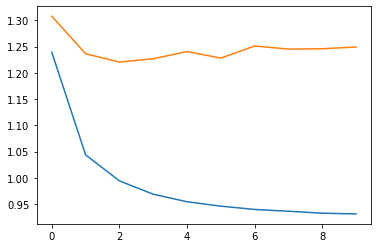

In [35]:
plt.plot(loss_train8)
plt.plot(loss_test8)
plt.show()

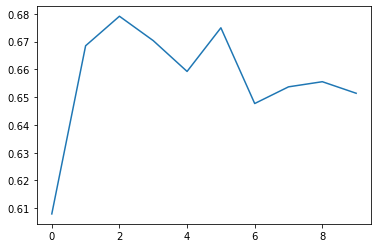

In [36]:
plt.plot(acc8)
plt.show()

In [37]:
print("Best accuracy: ",np.max(acc8)," Epoch: ", np.argmax(acc8))

Best accuracy:  0.6791493  Epoch:  2
